# ANALYZING MORTALITY RATES FROM PREVENTABLE CAUSES ACROSS ENGLAND

# Executive Summary

The data for this analysis was taken from NHS preventable diseases centre. The data only contains information about lives aged less than 75.

In this notebook, the main focus is to:

1. Analyze and visualize overall mortality rates across regions for each of the diseases
2. Analyze and visualize overall mortality rates across gender for each of the diseases
3. Analyze and visualize overall mortality rates across gender and regions for each of the diseases
4. Confirm the difference in mortality rate for each of the diseases across gender through hypothesis testing

The diseases being analyzed are:
1. Suicide
2. Liver disease
3. Cardiovascular disease
4. Respiratory disease
5. Cancer

# Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import openpyxl 
import matplotlib.pyplot as plt
from scipy import stats
import researchpy

# Load the datasets

In [3]:
#Load all the datasets provided into respective dataframes
suicide = pd.read_csv('data/410suiciderate.data.csv')
cancer = pd.read_csv('data/405iiunder75mortalityratefromcancerconsideredpreventable.data.csv')
liver = pd.read_csv('data/406iiunder75mortalityratefromliverdiseaseconsideredpreventable.data.csv')
resp = pd.read_csv('data/407iiunder75mortalityratefromrespiratorydiseaseconsideredpreventable.data.csv')
cardio = pd.read_csv('data/404iiunder75mortalityratefromcardiovasculardiseasesconsideredpreventable.data.csv')
file = 'data/laregionlookup2012_tcm77-368555.xls'
xl = pd.ExcelFile(file)
region = xl.parse('LA_region_2012')

# Data Preparation

1. Check the number of columns
2. Check total number of rows
3. Check the data type of each column
4. Check how many rows of each column has a value

In [4]:
suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17872 entries, 0 to 17871
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area Code       17872 non-null  object 
 1   Area Name       17872 non-null  object 
 2   Area Type       17872 non-null  object 
 3   Sex             17872 non-null  object 
 4   Age             17872 non-null  object 
 5   Category Type   1560 non-null   object 
 6   Category        1560 non-null   object 
 7   Time period     17872 non-null  object 
 8   Value           9319 non-null   float64
 9   Lower CI limit  9319 non-null   float64
 10  Upper CI limit  9319 non-null   float64
 11  Count           16806 non-null  float64
 12  Denominator     16806 non-null  float64
 13  Value note      8568 non-null   object 
dtypes: float64(5), object(9)
memory usage: 1.3+ MB


In [5]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17862 entries, 0 to 17861
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area Code       17862 non-null  object 
 1   Area Name       17862 non-null  object 
 2   Area Type       17862 non-null  object 
 3   Sex             17862 non-null  object 
 4   Age             17862 non-null  object 
 5   Category Type   1560 non-null   object 
 6   Category        1560 non-null   object 
 7   Time period     17862 non-null  object 
 8   Value           17445 non-null  float64
 9   Lower CI limit  17445 non-null  float64
 10  Upper CI limit  17445 non-null  float64
 11  Count           17526 non-null  float64
 12  Denominator     17526 non-null  float64
 13  Value note      432 non-null    object 
dtypes: float64(5), object(9)
memory usage: 1.3+ MB


In [5]:
liver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17862 entries, 0 to 17861
Data columns (total 14 columns):
Area Code         17862 non-null object
Area Name         17862 non-null object
Area Type         17862 non-null object
Sex               17862 non-null object
Age               17862 non-null object
Category Type     1560 non-null object
Category          1560 non-null object
Time period       17862 non-null object
Value             11897 non-null float64
Lower CI limit    11897 non-null float64
Upper CI limit    11897 non-null float64
Count             17526 non-null float64
Denominator       17526 non-null float64
Value note        5980 non-null object
dtypes: float64(5), object(9)
memory usage: 1.9+ MB


In [6]:
resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17862 entries, 0 to 17861
Data columns (total 14 columns):
Area Code         17862 non-null object
Area Name         17862 non-null object
Area Type         17862 non-null object
Sex               17862 non-null object
Age               17862 non-null object
Category Type     1560 non-null object
Category          1560 non-null object
Time period       17862 non-null object
Value             12482 non-null float64
Lower CI limit    12482 non-null float64
Upper CI limit    12482 non-null float64
Count             17526 non-null float64
Denominator       17526 non-null float64
Value note        5395 non-null object
dtypes: float64(5), object(9)
memory usage: 1.9+ MB


In [7]:
cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17862 entries, 0 to 17861
Data columns (total 14 columns):
Area Code         17862 non-null object
Area Name         17862 non-null object
Area Type         17862 non-null object
Sex               17862 non-null object
Age               17862 non-null object
Category Type     1560 non-null object
Category          1560 non-null object
Time period       17862 non-null object
Value             16991 non-null float64
Lower CI limit    16991 non-null float64
Upper CI limit    16991 non-null float64
Count             17526 non-null float64
Denominator       17526 non-null float64
Value note        886 non-null object
dtypes: float64(5), object(9)
memory usage: 1.9+ MB


Next, a funtion is defined to clean the data.

In [8]:
def data_prep(dataframe):
    #First merge the respective disease dataset with the region dataset to obtain region codes for all areas that are not set to areatype "Region"
    df = pd.merge(dataframe, region, how='left', left_on = 'Area Code', right_on = 'la_code')
    #After merge, the column region_code, which comes from region dataset is checked for null values and replaced with original values if it is null 
    df.region_code.fillna(df['Area Code'], inplace=True)
    #Another merge is performed to assign each region code to its respective region name
    df = pd.merge(dataframe, region, how='left', left_on = 'Area Code', right_on = 'region_code')
    #Only those rows are carried forward that have the following region_codes. Any blanks and nulls are eliminated
    region_codes = ['E12000001','E12000002','E12000003','E12000004','E12000005','E12000006','E12000007','E12000008','E12000009']
    df = df[df['region_code'].isin(region_codes)]
    #Only rows which have Sex = Male or Sex = Female are carried forward, eliminating rows with Sex = Persons
    df = df[df.Sex != 'Persons']
    #The time period column contains some dates in the mmm-yy format and some dates where it is Year1 - Year 5, eg 2012-14
    df['Year'], df['month'] = df['Time period'].str.split('-', 1).str
    df["month"] = pd.to_numeric(df["month"])
    indexNames = df[df['month'] > 12 ].index
    df.drop(indexNames , inplace=True)

    #Some of the dataframes had null values for the following 3 columns.
    #However, if rows containing null values for these columns are dropped, less than 50% data will remain for analysis, leading to incorrect conclusions
    #Hence, imputed null vaues in these columns with median. The reason for selecting median is that they are not affected by outliers.
    df['Value'] = df['Value'].fillna((df['Value'].median()))
    df['Lower CI limit'] = df['Lower CI limit'].fillna((df['Lower CI limit'].median()))
    df['Upper CI limit'] = df['Upper CI limit'].fillna((df['Upper CI limit'].median()))
    #Returning cleaned dataframe
    return df

# Exploratory Analysis

A few functions are defined here to create graphs that aid in visualizing and analyzing the data

In [9]:
#Function defined for distribution of disease rate and their respective confidence limits across regions. 
def rates_overview_region(dataframe):
    df=dataframe.groupby(['region_name'])["Value", "Lower CI limit","Upper CI limit"].apply(lambda x : x.astype(int).sum())
    df[-15:].plot( y=['Value', 'Lower CI limit','Upper CI limit'], figsize=(20,5), grid=True)

In [10]:
#Distribution of Disease by Region
def dis_reg(dataframe):
    df_g1 = dataframe.groupby('region_name')['Value'].sum()
    df2 =df_g1.to_frame()
    df2.reset_index(inplace=True)
    df2.columns = ['region_name','Value']
    df2.plot(kind='bar',x='region_name',y='Value')
    plt.title('Distribution of Disease by Region')
    plt.show()

In [11]:
#Distribution of Disease by Gender
def dis_gender(dataframe):
    df_g2 = dataframe.groupby('Sex')['Value'].sum()
    df2 =df_g2.to_frame()
    df2.reset_index(inplace=True)
    df2.columns = ['Sex','Value']
    df2.plot(kind='bar',x='Sex',y='Value')
    plt.title('Distribution of Disease by Gender')
    plt.show()

In [12]:
#Function to visualize distribution of disease rates across gender and region 
def dis_gender_reg(datframe):
    datframe.groupby(['Sex','region_name'])['Value'].sum().unstack('Sex').plot.bar()
    plt.title('Distribution of Disease by Region and Gender')

In [13]:
#Progression of disease over time
def time_prog(dataframe):
    plt.rcParams["figure.figsize"] = (10,10)
    dataframe.groupby(['region_name','Year'])['Value'].sum().unstack('region_name').plot.line()
    plt.title('Progression of disease over years')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, borderaxespad=0.)

# Hypothesis Testing

Few more functions are defined here to perform hypothesis testing.
Some of the tests performed here check for:
1. Normality of distribution
2. T-Test

In [14]:
#Function to create two datasets male and female to study the difference in mean
def diff_df(dataframe):
    male = dataframe[dataframe['Sex'] == 'Male'] 
    male.reset_index(inplace= True)
    male.rename(columns={'Value': 'ValueM'}, inplace=True)
    female = dataframe[dataframe['Sex'] == 'Female'] 
    female.reset_index(inplace= True)
    female.rename(columns={'Value': 'ValueF'}, inplace=True)
    diff = male['ValueM'] - female['ValueF']
    return diff

In [15]:
#Function to plot p-p plot to test if the data is normally distributed
def pplot(dataframe):
    stats.probplot(dataframe, plot= plt)
    plt.title('Gender P-P Plot') 
    plt.show()

In [16]:
#Function to further validate normal distribution through histograms
def hist(dataframe):
    dataframe.plot(kind= "hist", title= "Disease Values Histogram")
    plt.xlabel("Value")
    plt.show()

In [17]:
#Function to perform ttest
#Null hypothesis: No difference in suicide rates across Males and Females 
#Alternate hypothesis: Difference in suicide rates across Males and Females
def ttest(dataframe):
    male = dataframe[dataframe['Sex'] == 'Male'] 
    male.reset_index(inplace= True)
    male.rename(columns={'Value': 'ValueM'}, inplace=True)
    female = dataframe[dataframe['Sex'] == 'Female'] 
    female.reset_index(inplace= True)
    female.rename(columns={'Value': 'ValueF'}, inplace=True)
    descriptives, results = researchpy.ttest(male['ValueM'], female['ValueF'])
    print(descriptives)
    print(results)

# Results

### Data Cleaning

First, clean and prep all datasets and transform to necessary layout, removing any unwanted columns

In [18]:
df_suicide=data_prep(suicide)
df_suicide.drop(['Category Type', 'Age', 'Count','Denominator','Area Code', 'Category','Value note','la_code','la_name','month'], axis=1, inplace=True)

df_cancer = data_prep(cancer)
df_cancer.drop(['Category Type', 'Age', 'Count','Denominator','Area Code', 'Category','Value note','la_code','la_name','month'], axis=1, inplace=True)

df_liver = data_prep(liver)
df_liver.drop(['Category Type', 'Age', 'Count','Denominator','Area Code', 'Category','Value note','la_code','la_name','month'], axis=1, inplace=True)

df_resp = data_prep(resp)
df_resp.drop(['Category Type', 'Age', 'Count','Denominator','Area Code', 'Category','Value note','la_code','la_name','month'], axis=1, inplace=True)

df_cardio = data_prep(cardio)
df_cardio.drop(['Category Type', 'Age', 'Count','Denominator','Area Code', 'Category','Value note','la_code','la_name','month'], axis=1, inplace=True)

### Analyzing and Visualizing Data across all datasets

#### Analyzing Mortality rates due to suicide across different regions and gender

Some key insights:
1. South-east region has the highest mortality rate due to suicide
2. Overall, males tend to succumb to suicide as compared to females
3. Overall, the number of deaths due to suicide have remained same between 2001 and 2010. However, in 2006, most regions, especially South East region saw a noticeable dip in the suicide rates.
4. Suicide rates have not declined over the years. This is interesting because there is a decline in mortality rates across all other diseases as will be shown in the data analysis later. 
5. South East has the highest suicide rates despite having the second highest per capita income out of all the regions of England. It appears to be linked to population has South East has the highest population out of all the regions as per the census conducted in 2011.
6. London has the highest per capita income in the dataset, however it does not have lower suicide rates compared to other lower income regions. Hence, suicide does not seem to be linked to per capita income.

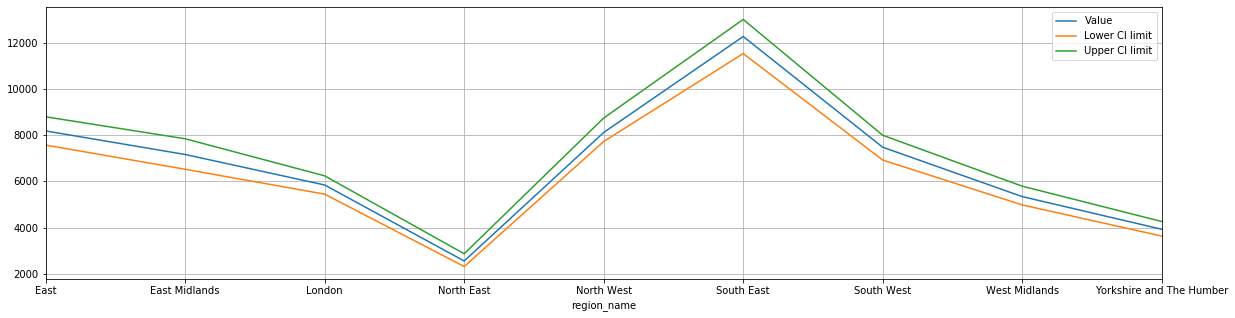

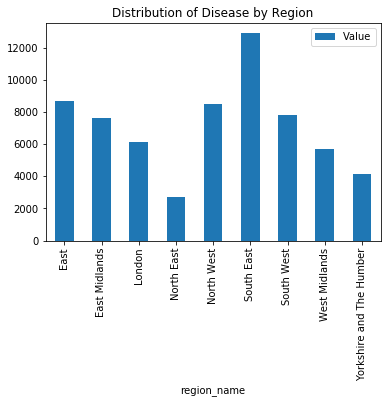

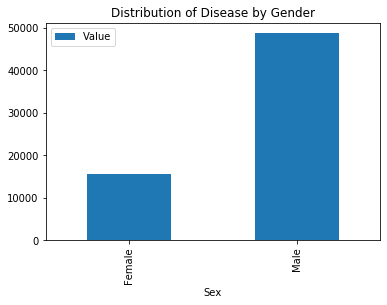

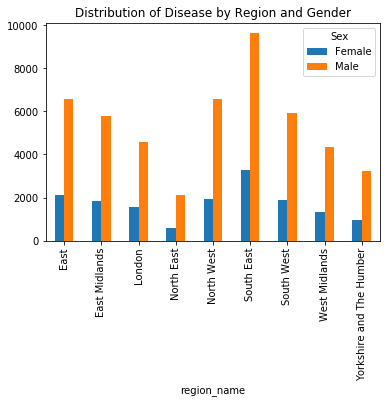

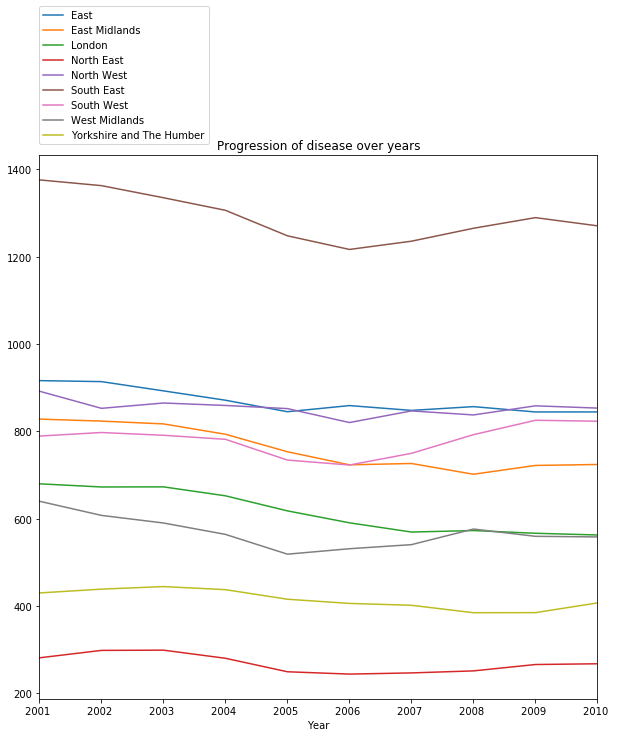

In [19]:
rates_overview_region(df_suicide)
dis_reg(df_suicide)
dis_gender(df_suicide)
dis_gender_reg(df_suicide)
time_prog(df_suicide)

#### Analyzing Mortality rates due to cardiovascular disease across different regions and gender

Some key insights:
1. South-east region has the highest mortality rate due to cardiovascular disease
2. Overall, males tend to succumb to cardiovascular disease as compared to females
3. Overall, the number of deaths due to cardiovascular disease has decreased significantly since 2001. This indicates a healthier lifestyle or availability of better medical resources.

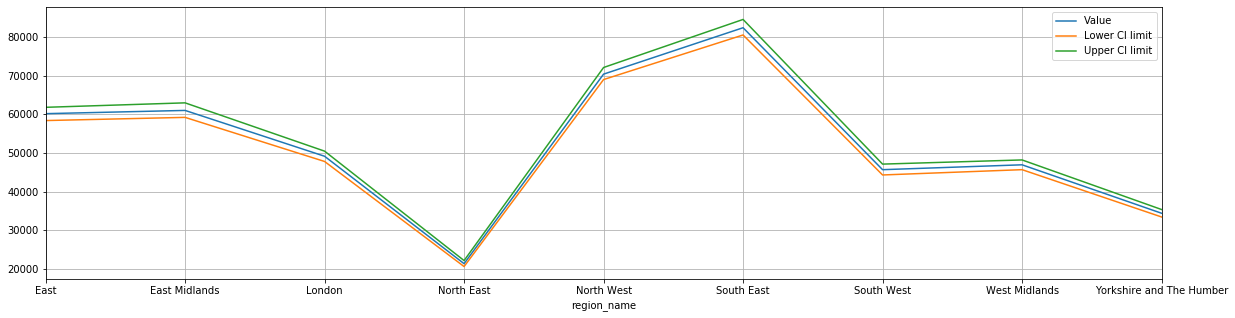

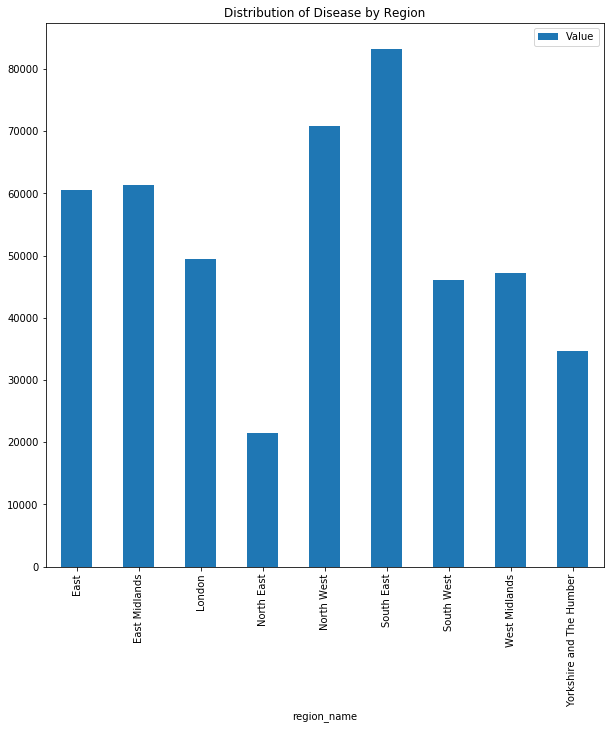

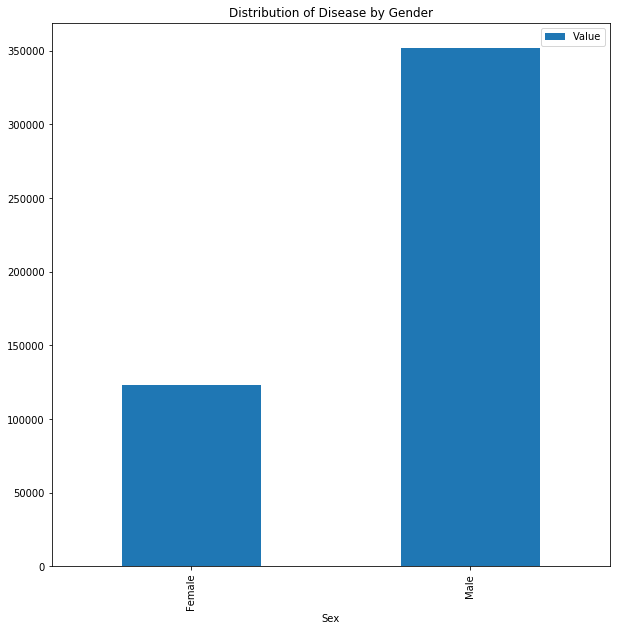

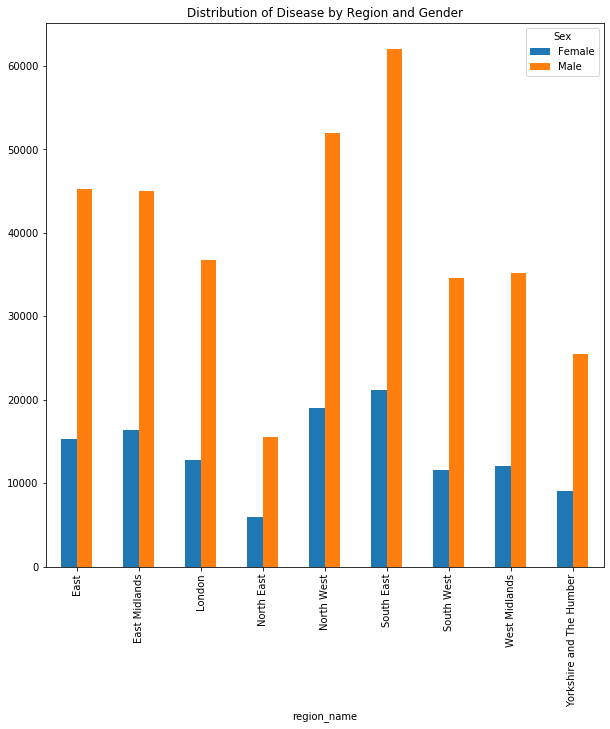

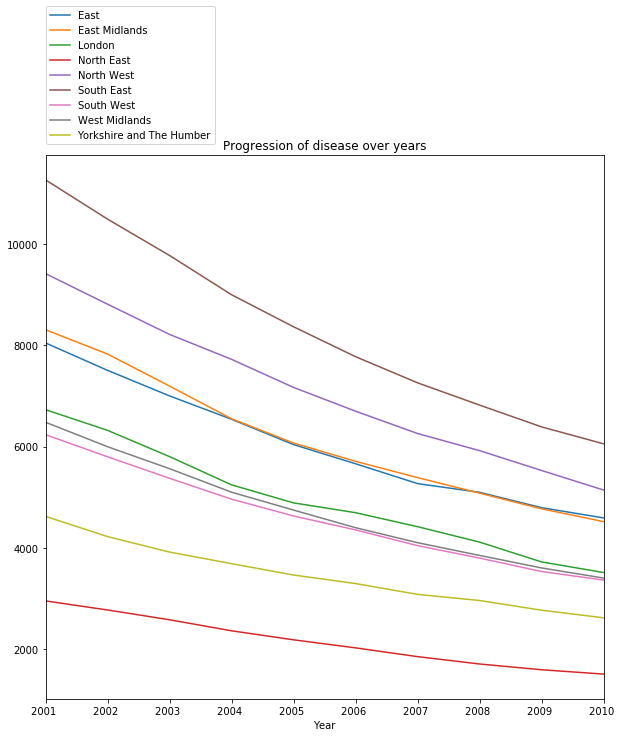

In [20]:
rates_overview_region(df_cardio)
dis_reg(df_cardio)
dis_gender(df_cardio)
dis_gender_reg(df_cardio)
time_prog(df_cardio)

#### Analyzing Mortality rates due to respiratory disease across different regions and gender

Some key insights:
1. South-east region has the highest mortality rate due to suicide
2. Overall, males tend to succumb to suicide as compared to females
3. Overall, the number of deaths due to suicide have remained same between 2001 and 2010. However, in 2006, most regions, especially South East region saw a noticeable dip in the suicide rates.

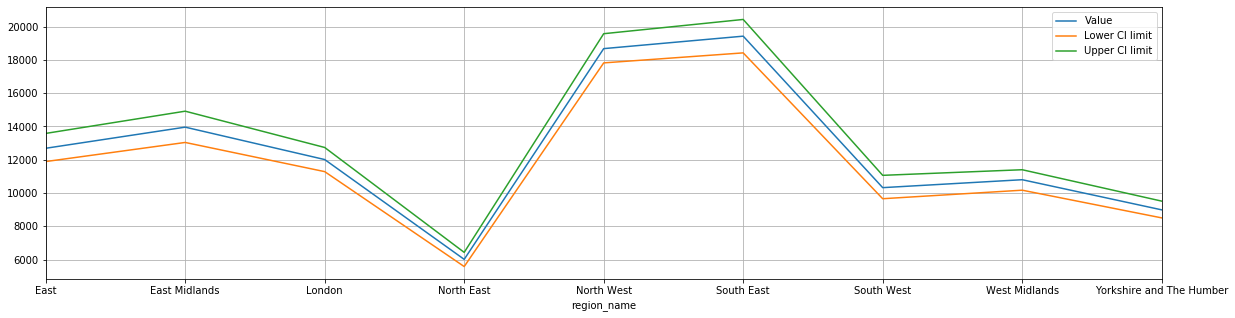

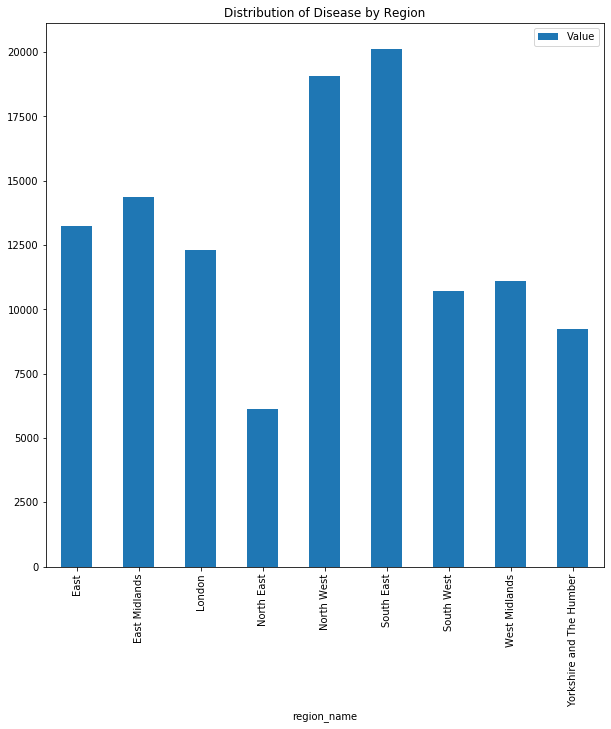

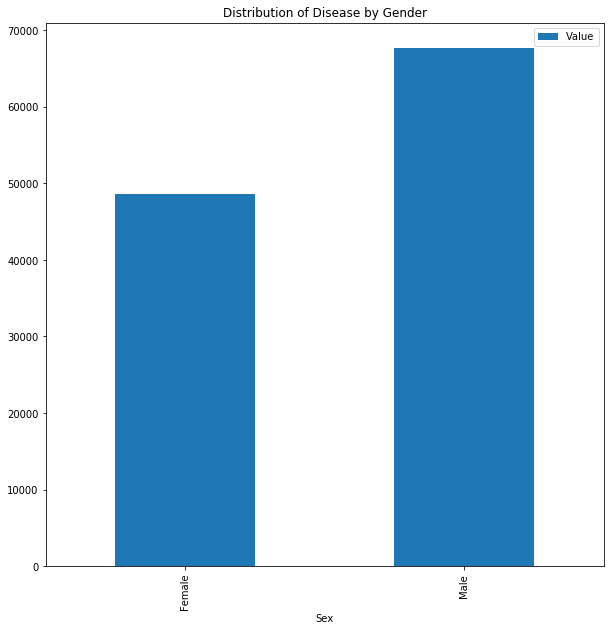

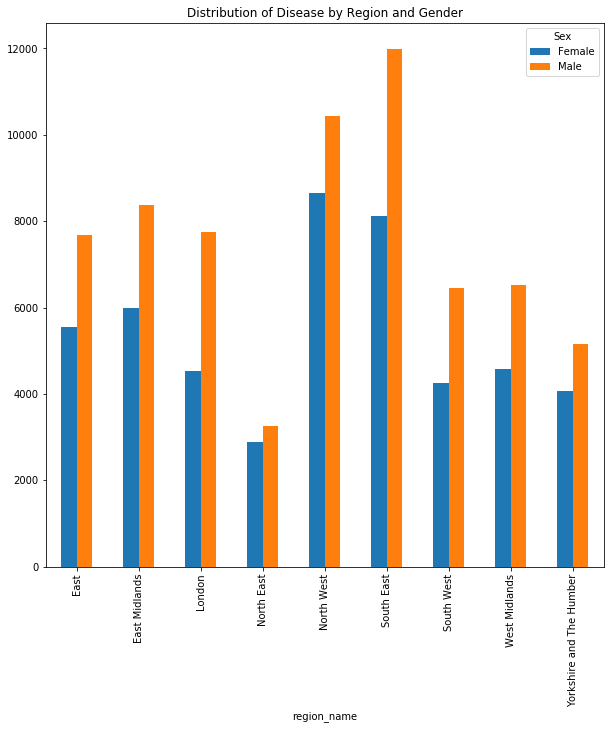

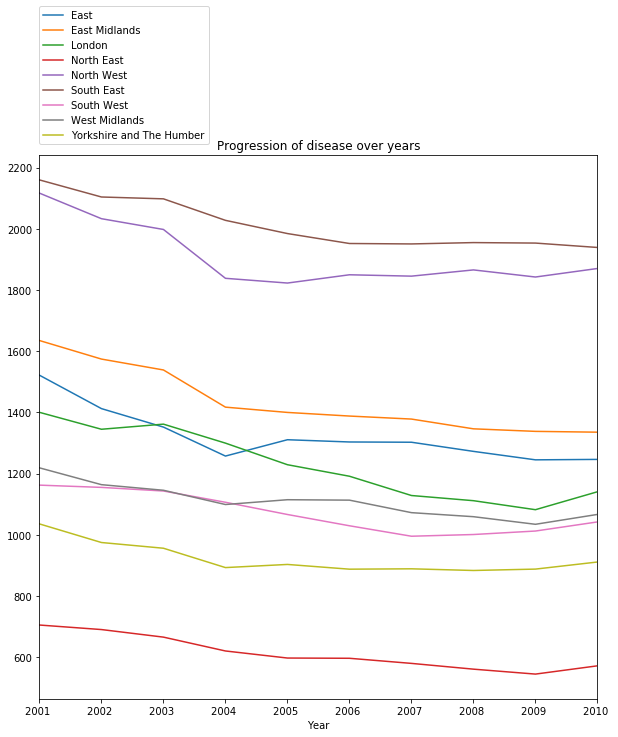

In [21]:
rates_overview_region(df_resp)
dis_reg(df_resp)
dis_gender(df_resp)
dis_gender_reg(df_resp)
time_prog(df_resp)

#### Analyzing Mortality rates due to liver disease across different regions and gender

Some key insights:
1. South-east and North-West regions have the highest mortality rate due to liver diseases
2. Overall, males tend to succumb to liver diseases as compared to females
3. Overall, the number of deaths due to liver diseases has increased at a steady rate across all regions, except London, where deaths due to liver diseases has dropped significantly since 2001. Decrease in deaths from liver diseases in London may possibly be due to lower alcohol consumption compared to other parts of the city, however the current data does not allow for this analysis and it is an interesting research question that can be explored.

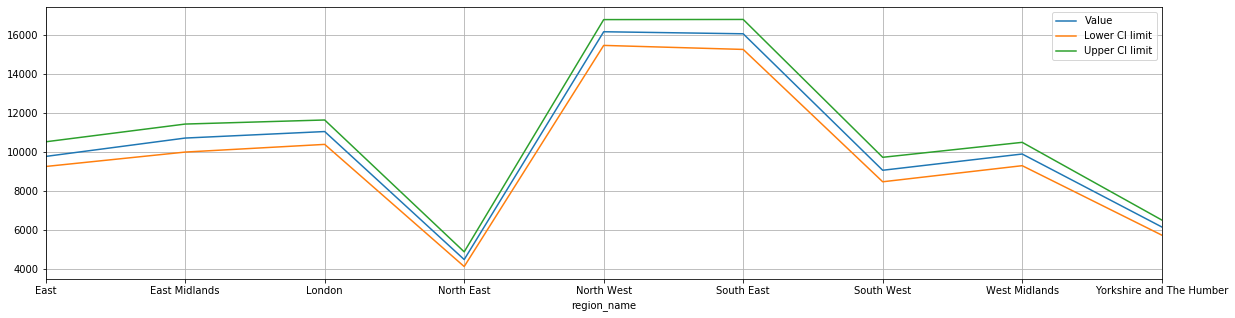

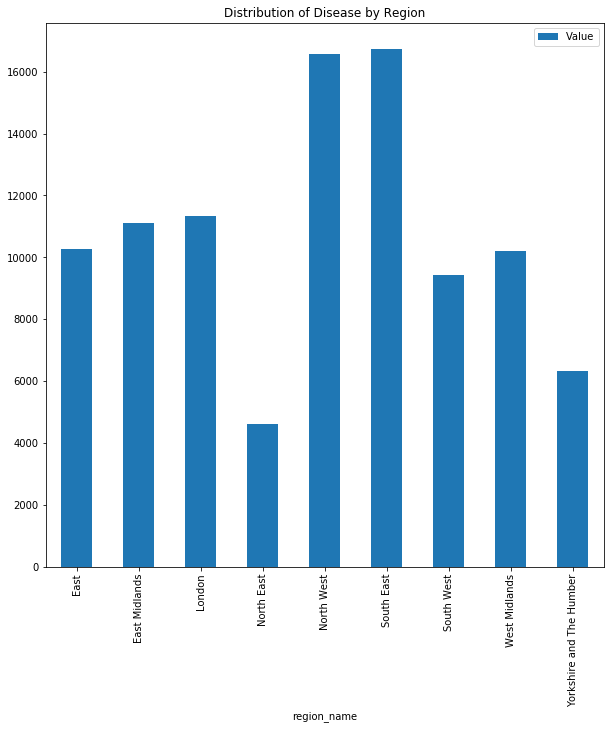

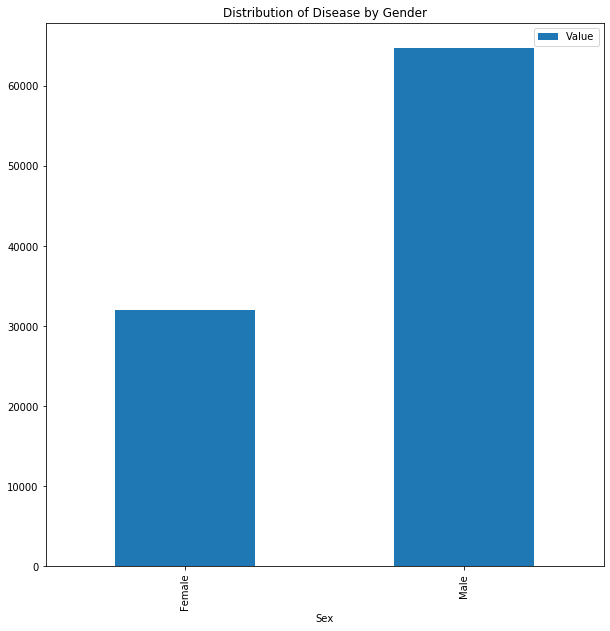

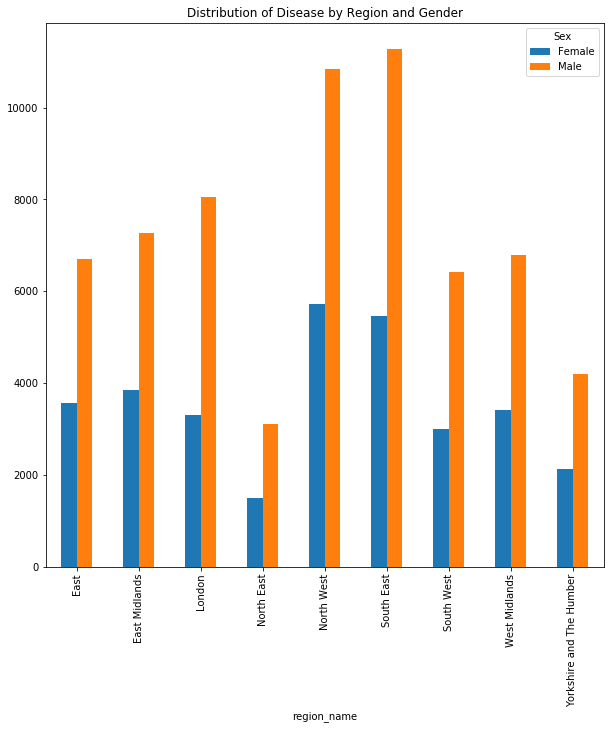

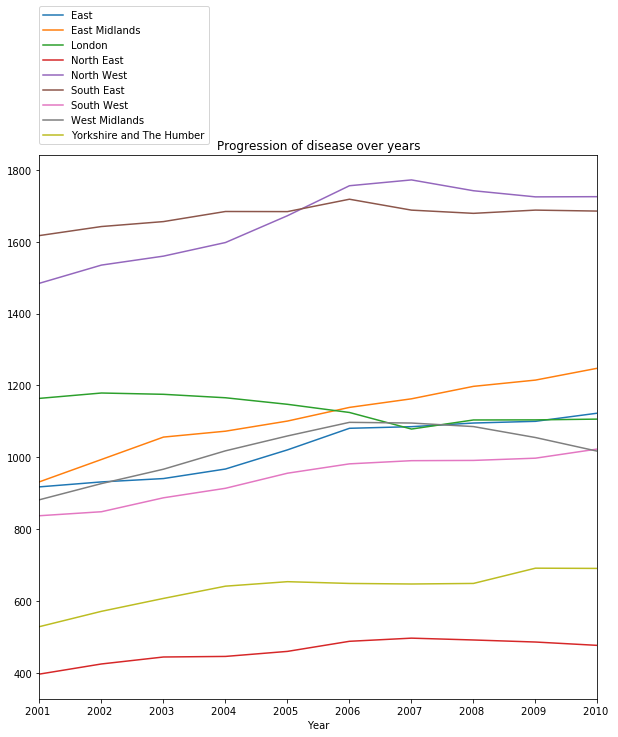

In [22]:
rates_overview_region(df_liver)
dis_reg(df_liver)
dis_gender(df_liver)
dis_gender_reg(df_liver)
time_prog(df_liver)

In [23]:
#### Analyzing Mortality rates due to cancer across different regions and gender

Some key insights:
1. South-east region has the highest mortality rate due to cancer
2. Overall, males tend to succumb to cancer as compared to females
3. Overall, the number of deaths due to cancer has dropped significantly across all regions since 2001, indicating probably healthier lifestyles or availability of better medical resources

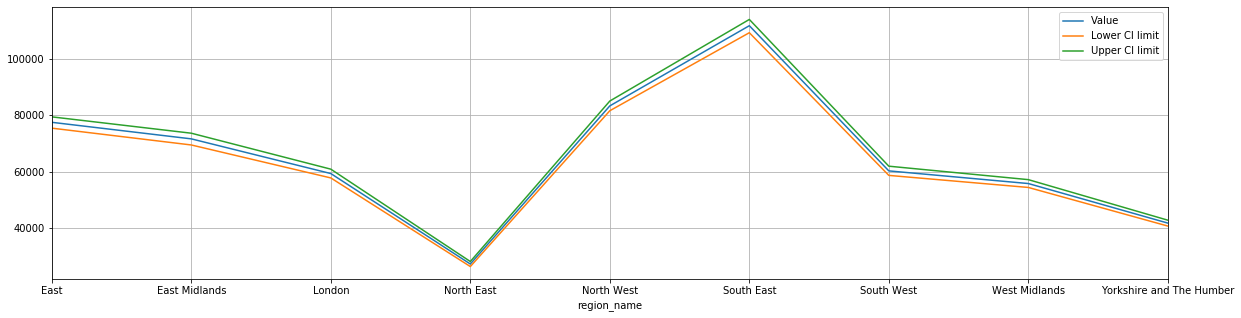

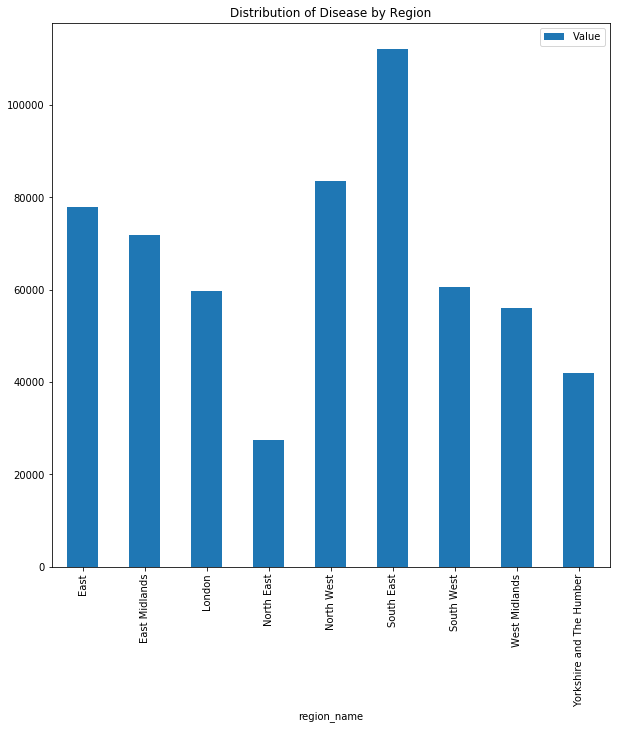

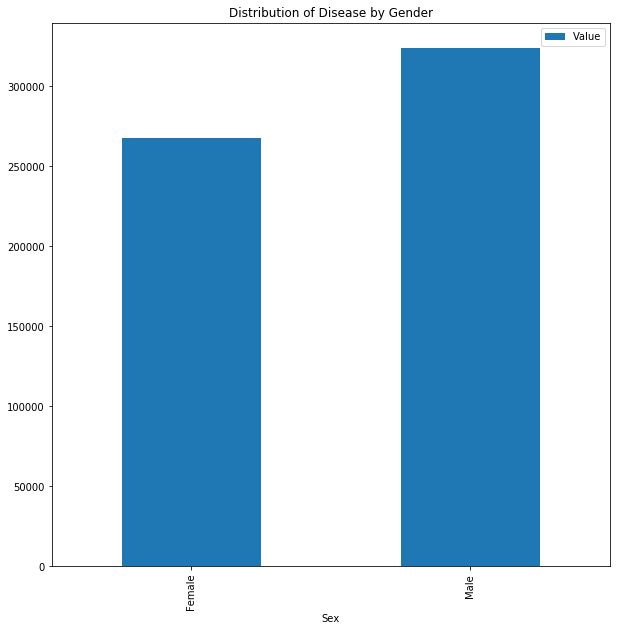

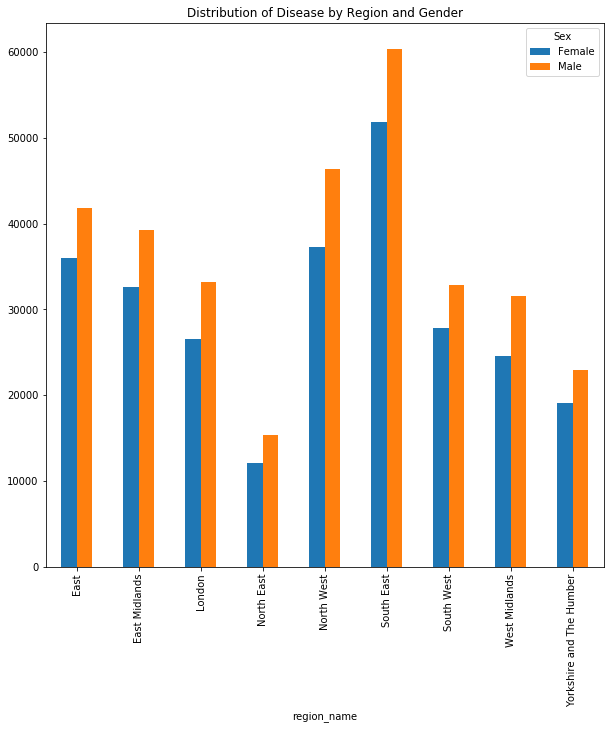

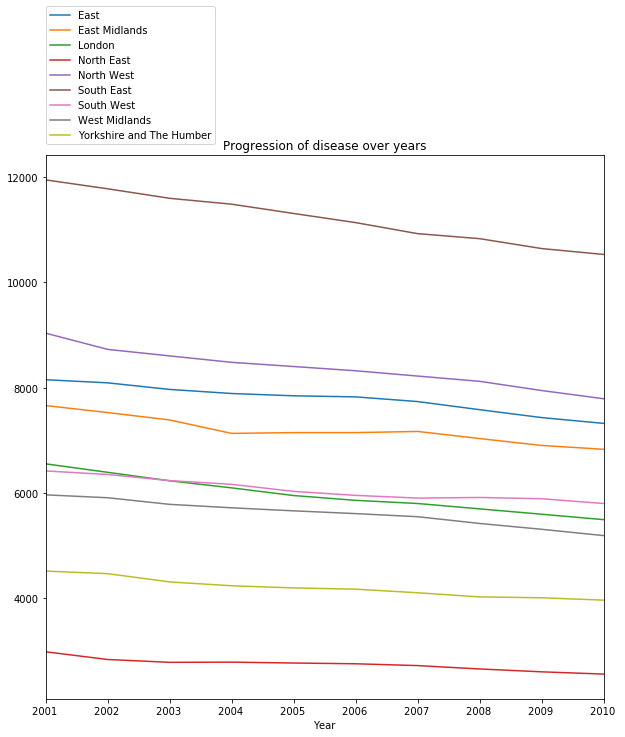

In [24]:
rates_overview_region(df_cancer)
dis_reg(df_cancer)
dis_gender(df_cancer)
dis_gender_reg(df_cancer)
time_prog(df_cancer)

### Analyzing and Visualizing Data across all datasets

Some key results:
1. Most of the data provided follows a somewhat normal distribution as displayed by the histogram plot and P-P plot
2. Upon carrying out hypothesis testing, using T-test, it becomes evident that the null hypothesis is rejected since p-value<0.05. This indicates, that for each of the diseases, there is a significant difference in the number of deaths between males and females

C:\Users\rimsh\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


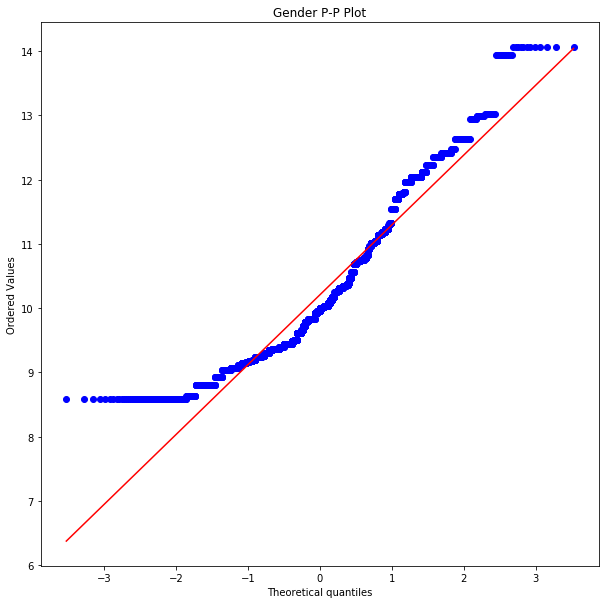

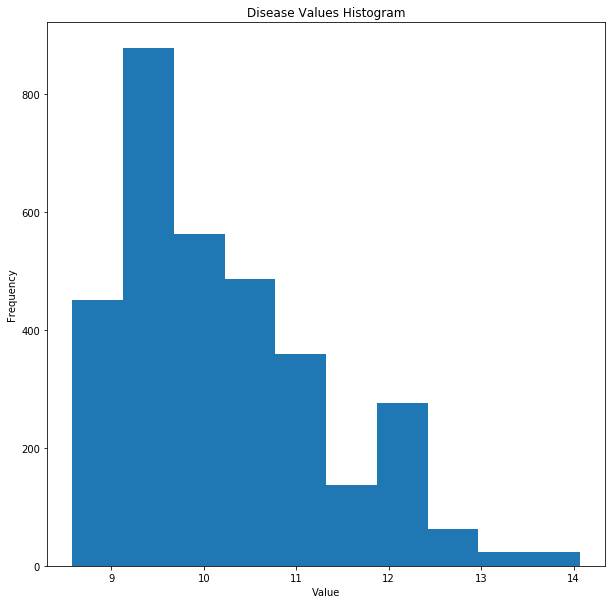

   Variable       N       Mean        SD        SE  95% Conf.   Interval
0    ValueM  3260.0  14.956524  1.291769  0.022624  14.912165  15.000883
1    ValueF  3260.0   4.749233  0.441037  0.007724   4.734087   4.764378
2  combined  6520.0   9.852878  5.194482  0.064331   9.726769   9.978988
                Independent t-test    results
0  Difference (ValueM - ValueF) =     10.2073
1            Degrees of freedom =   6518.0000
2                             t =    426.9645
3         Two side test p value =      0.0000
4        Difference < 0 p value =      1.0000
5        Difference > 0 p value =      0.0000
6                     Cohen's d =     10.5754
7                     Hedge's g =     10.5742
8                 Glass's delta =      7.9018
9                             r =      0.9826


In [25]:
diff=diff_df(df_suicide)
pplot(diff)
hist(diff)
ttest(df_suicide)

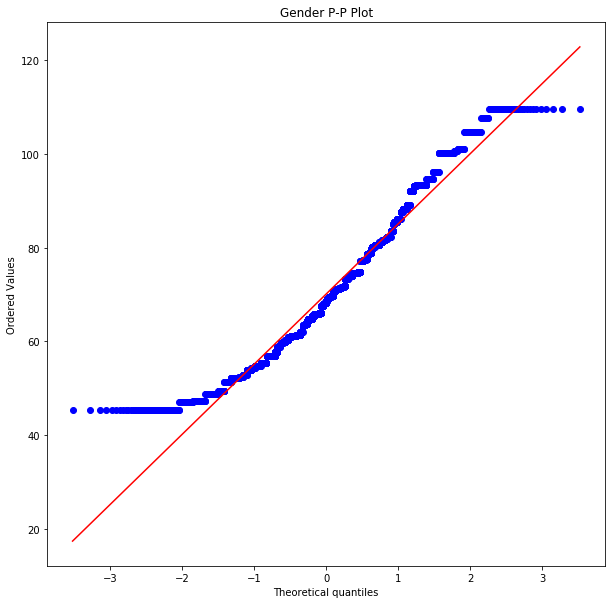

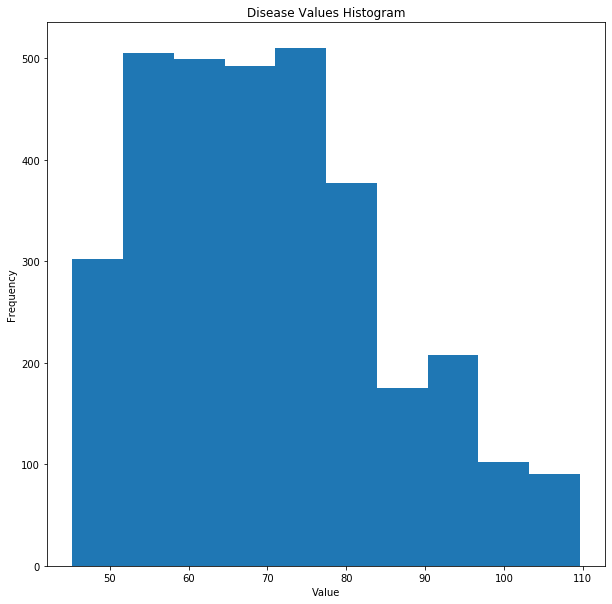

   Variable       N        Mean         SD        SE   95% Conf.    Interval
0    ValueM  3260.0  107.863873  25.518125  0.446930  106.987580  108.740166
1    ValueF  3260.0   37.780937  10.440257  0.182853   37.422419   38.139456
2  combined  6520.0   72.822405  40.101389  0.496633   71.848842   73.795969
                Independent t-test    results
0  Difference (ValueM - ValueF) =     70.0829
1            Degrees of freedom =   6518.0000
2                             t =    145.1325
3         Two side test p value =      0.0000
4        Difference < 0 p value =      1.0000
5        Difference > 0 p value =      0.0000
6                     Cohen's d =      3.5948
7                     Hedge's g =      3.5944
8                 Glass's delta =      2.7464
9                             r =      0.8739


In [26]:
diff=diff_df(df_cardio)
pplot(diff)
hist(diff)
ttest(df_cardio)

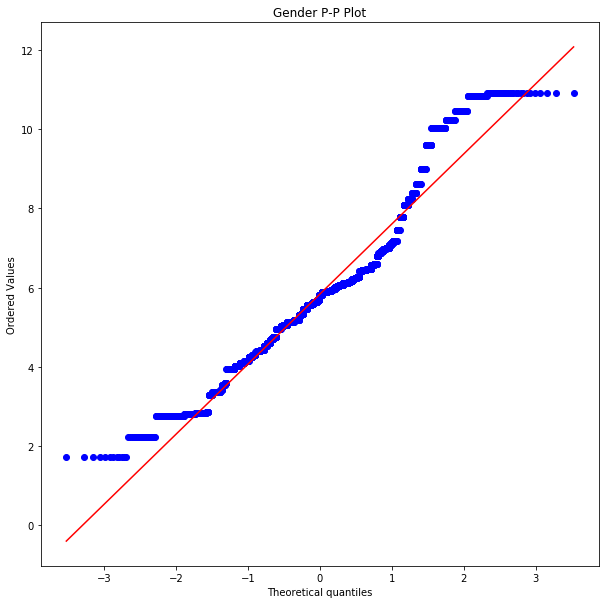

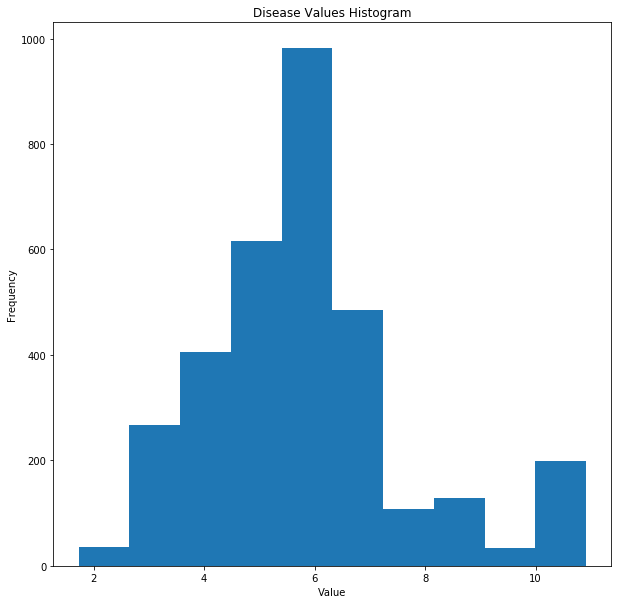

   Variable       N       Mean        SD        SE  95% Conf.   Interval
0    ValueM  3260.0  20.739678  3.939803  0.069003  20.604385  20.874971
1    ValueF  3260.0  14.903041  3.979156  0.069692  14.766397  15.039685
2  combined  6520.0  17.821359  4.918674  0.060915  17.701946  17.940773
                Independent t-test    results
0  Difference (ValueM - ValueF) =      5.8366
1            Degrees of freedom =   6518.0000
2                             t =     59.5132
3         Two side test p value =      0.0000
4        Difference < 0 p value =      1.0000
5        Difference > 0 p value =      0.0000
6                     Cohen's d =      1.4741
7                     Hedge's g =      1.4739
8                 Glass's delta =      1.4815
9                             r =      0.5934


In [27]:
diff=diff_df(df_resp)
pplot(diff)
hist(diff)
ttest(df_resp)

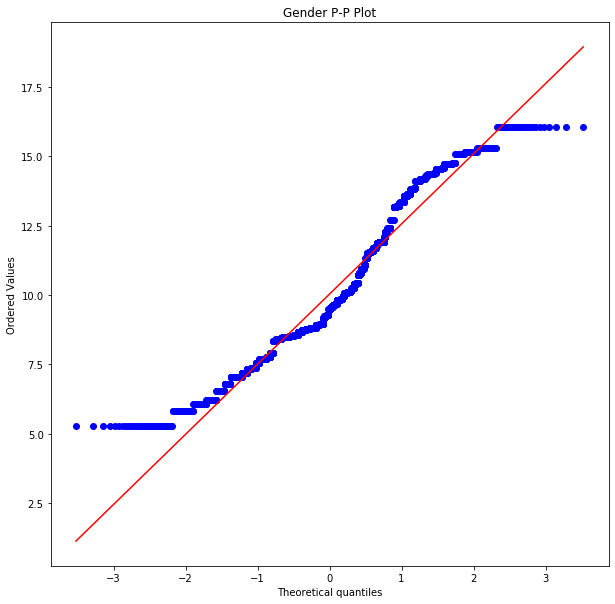

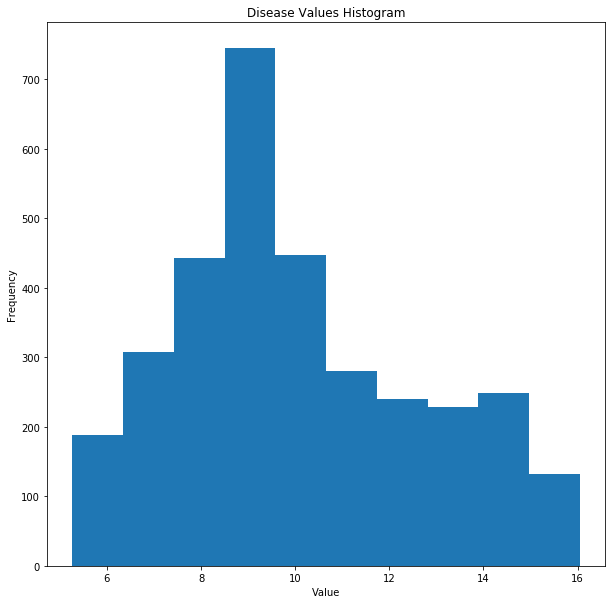

   Variable       N       Mean        SD        SE  95% Conf.   Interval
0    ValueM  3260.0  19.834359  4.557600  0.079823  19.677851  19.990867
1    ValueF  3260.0   9.799758  2.323892  0.040701   9.719956   9.879561
2  combined  6520.0  14.817059  6.185568  0.076605  14.666888  14.967229
                Independent t-test    results
0  Difference (ValueM - ValueF) =     10.0346
1            Degrees of freedom =   6518.0000
2                             t =    111.9925
3         Two side test p value =      0.0000
4        Difference < 0 p value =      1.0000
5        Difference > 0 p value =      0.0000
6                     Cohen's d =      2.7739
7                     Hedge's g =      2.7736
8                 Glass's delta =      2.2017
9                             r =      0.8112


In [28]:
diff=diff_df(df_liver)
pplot(diff)
hist(diff)
ttest(df_liver)

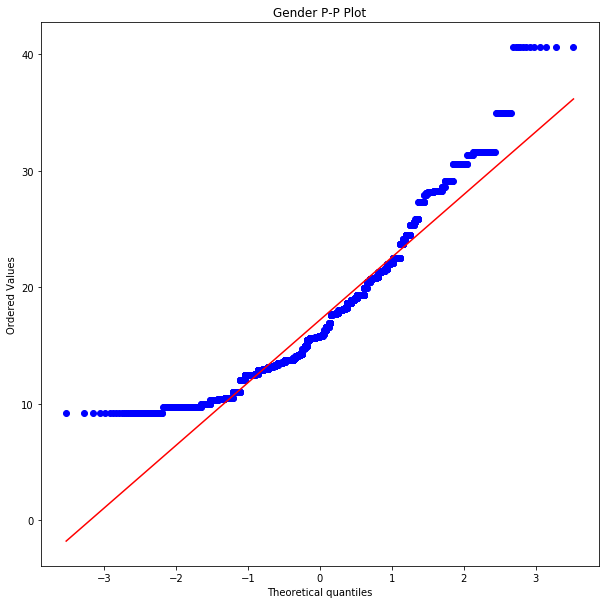

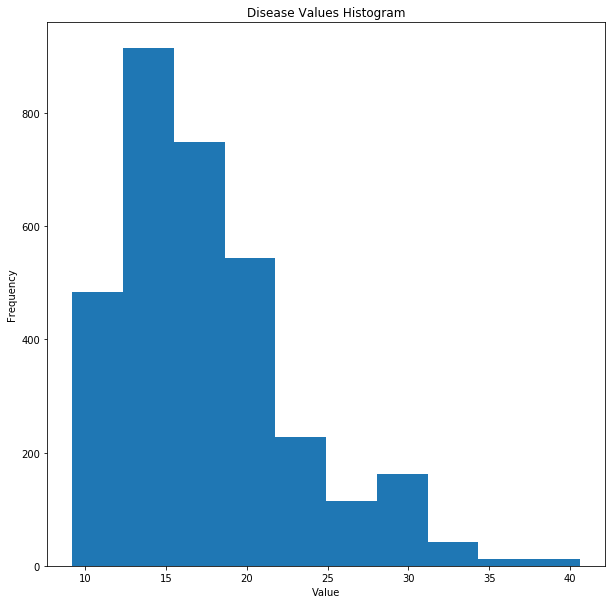

   Variable       N       Mean         SD        SE  95% Conf.   Interval
0    ValueM  3260.0  99.320282  12.502147  0.218966  98.890958  99.749606
1    ValueF  3260.0  82.135013   7.865126  0.137752  81.864925  82.405102
2  combined  6520.0  90.727648  13.524419  0.167492  90.399308  91.055987
                Independent t-test    results
0  Difference (ValueM - ValueF) =     17.1853
1            Degrees of freedom =   6518.0000
2                             t =     66.4314
3         Two side test p value =      0.0000
4        Difference < 0 p value =      1.0000
5        Difference > 0 p value =      0.0000
6                     Cohen's d =      1.6454
7                     Hedge's g =      1.6452
8                 Glass's delta =      1.3746
9                             r =      0.6354


In [29]:
diff=diff_df(df_cancer)
pplot(diff)
hist(diff)
ttest(df_cancer)

# Conclusion

From the analysis of the death rates across different regions of England, it becomes evident that the South-east region has the highest mortality rate when compared to the other regions of England. This can indicate a few things:
1. Poor lifestyle probably caused by high-stress jobs
2. Poor lifestyle probably caused by low-income households
3. Lack of good or affordable medical resources
4. Higher healthcare prices
A further analysis on the demography of the people living in these regions, will help in explaining the large disparity in mortality between Southeast and other regions.
Additionally, it was interesting to note, that mortality rates were higher among men when compared to women. This could be attributed to a multiple reasons, such as:
1. The type of occupation. A high stress profession like being in law enforcement or banking industry can lead to deaths from these diseases.
2. Genetics. The diseases used for this analysis affect men more than women.

# Limitations: 
1. Historical data is used whereas in recent year there have been improvements in healthcare. An analysis of more recent data may indicate the declining mortality rates from diseases considered preventable. 

2. The results may be biased due to sampling errors in data collection. For example, the data collected from the male population is higher than the female population, which is why mortality from males appears higher in the analysis. Several studies have shown that female healthcare is often neglected compared to males.

3. Data for age was not provided. It would be interesting to analyze how mortality from diseases considered preventable vary across different age groups.